In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [3]:
df = pd.read_csv("../data/processed/news_clean.csv")

print(df.head())
print(df['label'].value_counts())


                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  \
0  December 31, 2017      0   
1  December 31, 2017      0   
2  December 30, 2017      0   
3  December 29, 2017      0   
4  December 25, 2017      0   

                                           full_text  text_len  \
0   Donald Trump Sends Ou

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [5]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (35918, 10000)


In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB()
}

results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    results[name] = acc


=== Training Logistic Regression ===
Accuracy: 0.988641425389755
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


=== Training Linear SVM ===
Accuracy: 0.9961024498886414
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


=== Training Naive Bayes ===
Accuracy: 0.9506681514476615
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4696
           1       0.94      0.95      0.95      4284


Best model: Linear SVM


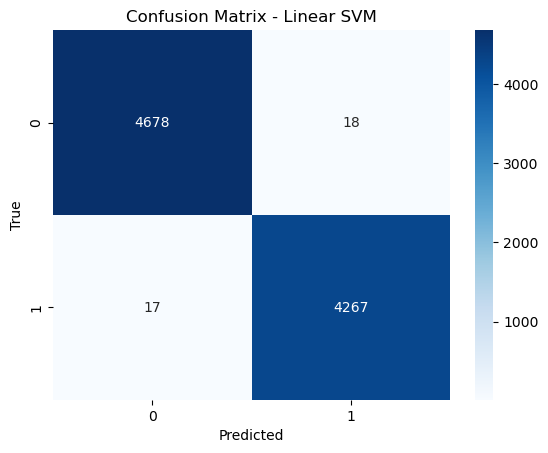

In [7]:
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name}")

best_model = models[best_model_name]
y_pred = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [8]:
joblib.dump(best_model, "../models/tfidf_best_model.pkl")
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")

print("Model and vectorizer saved.")

Model and vectorizer saved.


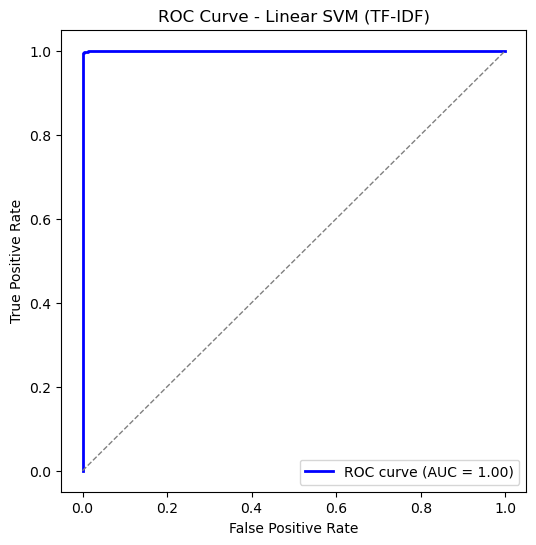

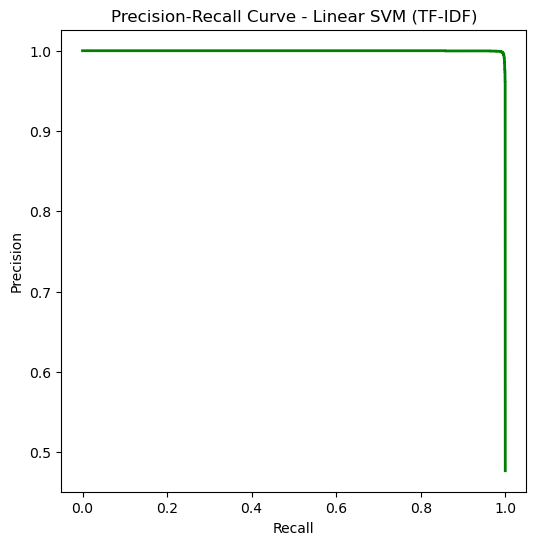

In [10]:
# decision_function gives scores (not probabilities, but good for curves)
y_scores = best_model.decision_function(X_test_tfidf)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear SVM (TF-IDF)")
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color="green", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Linear SVM (TF-IDF)")
plt.show()